In [1]:
from Utils import true, false, evaluate_model, impute_data, resample_data, load_data
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

player_data = load_data('data.csv')
imputed_player_data = impute_data(player_data)
columns_to_exclude = ['steam_id', 'created_at', 'name', 'total_matches', 'updated_at', 'has_ban', 'rank_premier', 'rank_faceit_elo']
X = imputed_player_data.drop(columns=columns_to_exclude)
y = imputed_player_data['has_ban'].map({true: 1, false: 0})

Loading data from data.csv...
Loaded 308148 players from CSV
Imputing data...
Data imputation completed in 428.7254524230957 seconds



## Approach 1: Single Test Split
---
This is the traditional approach where we split data once into training and testing sets.

Resampling data...

Original distribution:
  Banned: 35,411 (14.36%)
  Non-banned: 211,107 (85.64%)

Resampled distribution:
  Banned: 208,815 (53.55%)
  Non-banned: 181,136 (46.45%)
Data resampling completed in 79.3731005191803 seconds



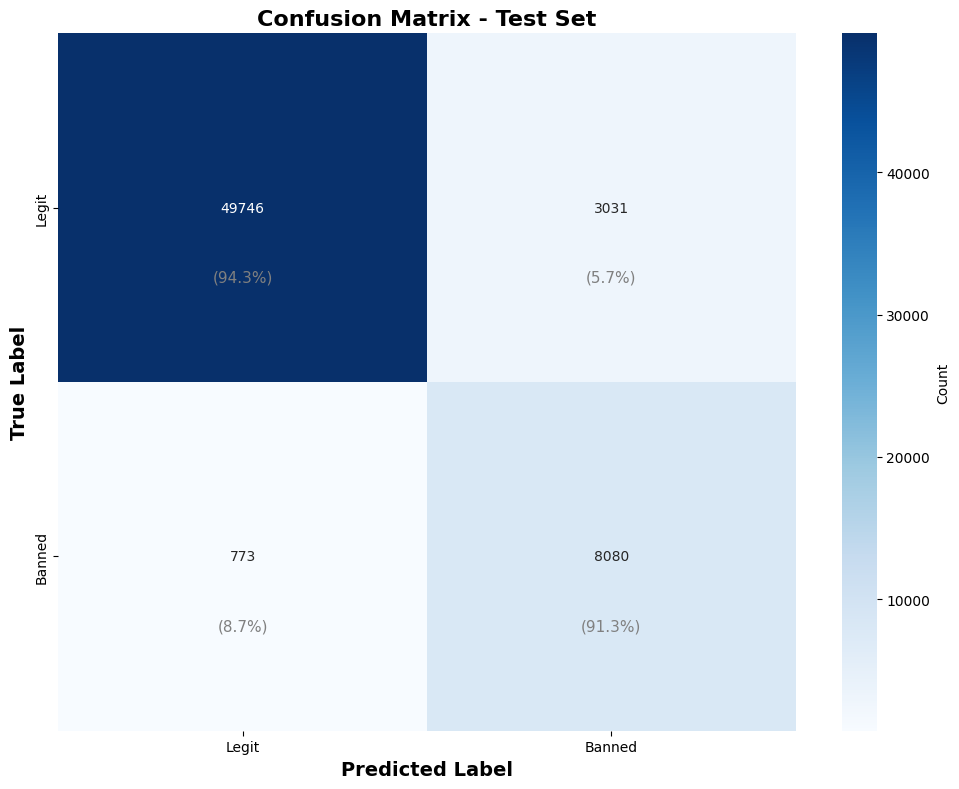

Metrics:
  ROC-AUC Score:           0.9755
  Precision (Banned):      0.7272
  Recall (Banned):         0.9127
  F1-Score (Banned):       0.8095
  False Positive Rate:     0.0574 (3,031 legit players incorrectly flagged)
  False Negative Rate:     0.0873 (773 cheaters missed)
  True Positives:          8,080 cheaters correctly identified
  True Negatives:          49,746 legit players correctly identified


In [2]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train_resampled, y_train_resampled = resample_data(X_train, y_train)

clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=100,
    random_state=42,
    n_jobs=-1
)

clf.fit(X_train_resampled, y_train_resampled)
evaluate_model(clf, X_test, y_test, show_plot=True)

## Approach 2: K-Fold Cross-Validation
Now let's implement k-fold cross-validation and see does it perform much better

In [3]:
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

fold_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'roc_auc': []
}

print(f"Running 5-Fold Cross-Validation...")

for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print(f"\nFold {fold_idx}/{k}")

    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]
    
    X_train_resampled, y_train_resampled = resample_data(X_train_fold, y_train_fold)
    
    clf_fold = RandomForestClassifier(
        n_estimators=100,
        max_depth=100,
        random_state=42,
        n_jobs=-1
    )
    clf_fold.fit(X_train_resampled, y_train_resampled)
    
    y_pred = clf_fold.predict(X_test_fold)
    y_pred_proba = clf_fold.predict_proba(X_test_fold)[:, 1]
    
    accuracy = accuracy_score(y_test_fold, y_pred)
    precision = precision_score(y_test_fold, y_pred)
    recall = recall_score(y_test_fold, y_pred)
    f1 = f1_score(y_test_fold, y_pred)
    roc_auc = roc_auc_score(y_test_fold, y_pred_proba)
    
    fold_metrics['accuracy'].append(accuracy)
    fold_metrics['precision'].append(precision)
    fold_metrics['recall'].append(recall)
    fold_metrics['f1'].append(f1)
    fold_metrics['roc_auc'].append(roc_auc)

Running 5-Fold Cross-Validation...


Fold 1/5
Resampling data...

Original distribution:
  Banned: 35,411 (14.36%)
  Non-banned: 211,107 (85.64%)

Resampled distribution:
  Banned: 208,838 (53.58%)
  Non-banned: 180,922 (46.42%)
Data resampling completed in 81.67561340332031 seconds


Fold 2/5
Resampling data...

Original distribution:
  Banned: 35,411 (14.36%)
  Non-banned: 211,107 (85.64%)

Resampled distribution:
  Banned: 208,883 (53.55%)
  Non-banned: 181,186 (46.45%)
Data resampling completed in 107.47910499572754 seconds


Fold 3/5
Resampling data...

Original distribution:
  Banned: 35,411 (14.36%)
  Non-banned: 211,107 (85.64%)

Resampled distribution:
  Banned: 208,894 (53.55%)
  Non-banned: 181,190 (46.45%)
Data resampling completed in 107.56406283378601 seconds


Fold 4/5
Resampling data...

Original distribution:
  Banned: 35,411 (14.36%)
  Non-banned: 211,108 (85.64%)

Resampled distribution:
  Banned: 208,935 (53.60%)
  Non-banned: 180,896 (46.40%)
Data resampling comple

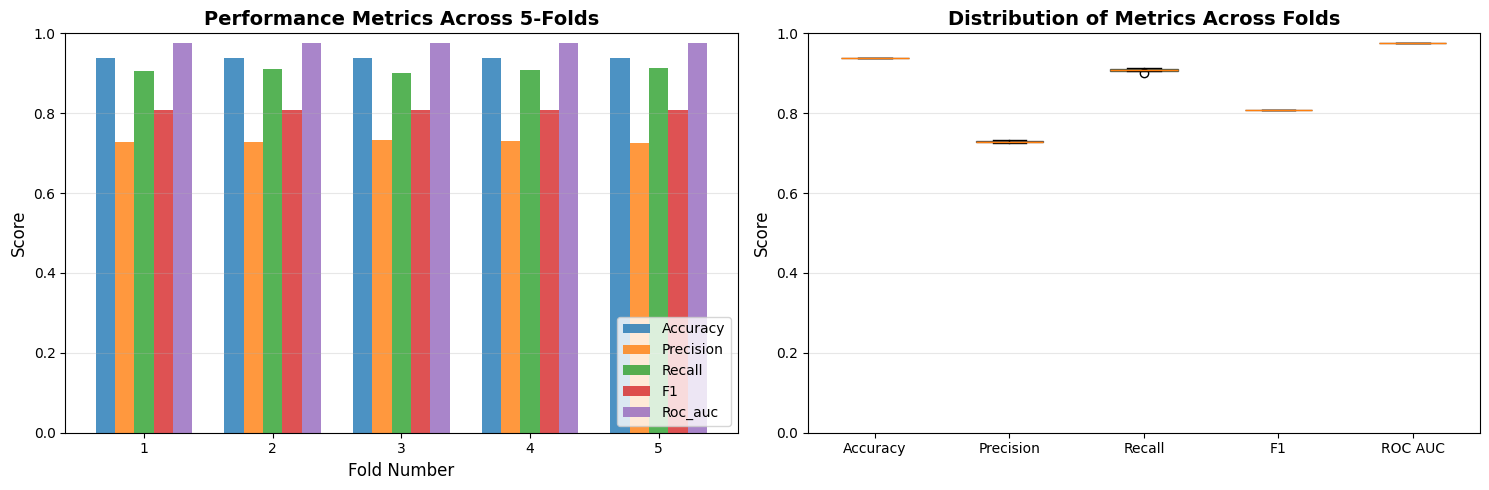

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

ax1 = axes[0]
x = np.arange(1, k + 1)
width = 0.15

for idx, (metric_name, values) in enumerate(fold_metrics.items()):
    offset = (idx - 2) * width
    ax1.bar(x + offset, values, width, label=metric_name.capitalize(), alpha=0.8)

ax1.set_xlabel('Fold Number', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Performance Metrics Across 5-Folds', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_ylim(0, 1)
ax1.legend(loc='lower right')
ax1.grid(axis='y', alpha=0.3)

ax2 = axes[1]
metric_data = [fold_metrics[m] for m in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']]
bp = ax2.boxplot(metric_data, tick_labels=['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC'], patch_artist=True)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax2.set_ylabel('Score', fontsize=12)
ax2.set_title('Distribution of Metrics Across Folds', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 1)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Results
---
K-fold cross validation does not seem particularly useful to me here considering the size of my dataset. The results across all folds are essentially identical and identical with the single test split. Since it takes a considerable amount of time to run my notebooks due to imputation, I will not implement cross fold validation at least for now.